In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import cnn

In [2]:
import pickle
from mnist import MNIST
from time import time

print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255)

Loading dataset....


In [3]:
def one_hot_encode(labels):
    y_inp=np.zeros((len(labels),10))
    for ind,val in enumerate(labels):
        y_inp[ind][val]=1
    return y_inp

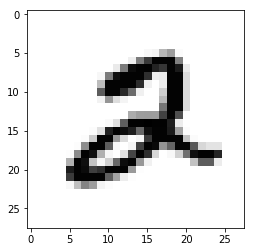

In [4]:
plt.imshow(X_train[5].reshape(28,28), cmap='Greys')
plt.show()

In [5]:
def batch_gen(st=0,size=20,validate=False):
    if validate:
        X=X_test[st:st+size].reshape(-1,28,28,1)
        labels=y_test[st:st+size]
    else:
        X=X_train[st:st+size].reshape(-1,28,28,1)
        labels=y_train[st:st+size]
    y=one_hot_encode(labels)
    return X,y

In [6]:
nn=cnn.conv_net()

# Inititalize filters and bias

In [7]:
w0,b0=nn.init_kernel_bias(num_inp_channels=1,kernel_size=5,num_kernels=6)
w1,b1=nn.init_kernel_bias(num_inp_channels=6,kernel_size=5,num_kernels=16)

# Initialize fully connected layer

In [8]:
import nnet
ann=nnet.neural_net(nrons=[784,128,40,10])
ann.activations(func=['relu','relu','sigmoid'])

# CNN and FC with backprop

In [9]:
def train(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,ann
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
    pool0,max_index0=nn.max_pool(aconv0)

    conv1=nn.conv2d(pool0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,max_index1=nn.max_pool(aconv1)

    r,c,d=pool1.shape[1:]
    flat=pool1.reshape(-1,r*c*d)

    err1=[]
    for flat_layer,ohe_cor in zip(flat,y_inp):
        ott=ann.feed_forward(flat_layer)
        ans=ott.argmax()
        cor=ohe_cor.argmax()
        err1.append(ann.backprop(ohe_cor)[0])

    err1=np.array(err1).reshape(-1,r,c,d)
    # Back prop CNN
    d_aconv1=nn.max_pool_back(errors=err1,inp=aconv1,max_index=max_index1)
    d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
    d_pool0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=pool0,kernels=w1,biases=b1)
    w1+=d_w1
    b1+=d_b1

    d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,max_index=max_index0)
    d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
    d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0,layer=0)
    w0+=d_w0
    b0+=d_b0

In [10]:
def validate(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,ann
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
    pool0,max_index0=nn.max_pool(aconv0)

    conv1=nn.conv2d(pool0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,max_index1=nn.max_pool(aconv1)

    r,c,d=pool1.shape[1:]
    flat=pool1.reshape(-1,r*c*d)
    
    ans=[]
    cor=[]
    for flat_layer,ohe_cor in zip(flat,y_inp):
        ott=ann.feed_forward(flat_layer)
        ans.append(ott.argmax())
        cor.append(ohe_cor.argmax())
    return ans,cor

In [11]:
X_train.shape,X_test.shape

((60000, 784), (10000, 784))

In [14]:
st=0

In [19]:
while (st+20)<60000:
    perc=st/600
    print("\rProgress: {:.2f} %".format(perc),end='')
    inp,y_inp=batch_gen(st,size=20)
    train(inp,y_inp)
    st+=20
    if not perc%5:
        sz=10000
        inp,y_inp=batch_gen(0,size=sz,validate=True)
        ans,cor=validate(inp,y_inp)
        ncor=0
        for i,j in zip(ans,cor):
            if i==j:
                ncor+=1
        acc=ncor*100/sz
        if acc>95:
            nn.learning_rate=0.001
        print("\nValidation Acc: {} %".format(acc))

Progress: 15.00 %
Validation Acc: 97.59 %
Progress: 20.00 %
Validation Acc: 97.6 %
Progress: 25.00 %
Validation Acc: 97.8 %
Progress: 30.00 %
Validation Acc: 97.76 %
Progress: 35.00 %
Validation Acc: 97.95 %
Progress: 40.00 %
Validation Acc: 98.06 %
Progress: 45.00 %
Validation Acc: 97.76 %
Progress: 50.00 %
Validation Acc: 97.76 %
Progress: 55.00 %
Validation Acc: 97.93 %
Progress: 60.00 %
Validation Acc: 97.28 %
Progress: 65.00 %
Validation Acc: 97.66 %
Progress: 70.00 %
Validation Acc: 98.02 %
Progress: 75.00 %
Validation Acc: 97.51 %
Progress: 80.00 %
Validation Acc: 98.03 %
Progress: 85.00 %
Validation Acc: 98.15 %
Progress: 90.00 %
Validation Acc: 97.95 %
Progress: 95.00 %
Validation Acc: 98.26 %
Progress: 99.93 %

In [ ]:
ck=np.random.randint(0,60000-100)
inp,y_inp=batch_gen(ck,size=1)
ans,cor=validate(inp,y_inp)
print(ans,cor)
plt.imshow(inp[0].reshape(28,28), cmap='Greys')

In [ ]:
conv0=nn.conv2d(inp,w0,b0)
aconv0=nn.relu(conv0)
pool0,max_index0=nn.max_pool(aconv0)

conv1=nn.conv2d(pool0,w1,b1)
aconv1=nn.relu(conv1)
pool1,max_index1=nn.max_pool(aconv1)

r,c,d=pool1.shape[1:]
flat=pool1.reshape(-1,r*c*d)

for flat_layer,ohe_cor in zip(flat,y_inp):
    ott=ann.feed_forward(flat_layer)
print(ott)

In [ ]:
# Feed Forward
conv0=nn.conv2d(inp,w0,b0)
aconv0=nn.relu(conv0)
pool0,max_index0=nn.max_pool(aconv0)
conv1=nn.conv2d(pool0,w1,b1)
aconv1=nn.relu(conv1)
pool1,max_index1=nn.max_pool(aconv1)
r,c,d=pool1.shape[1:]
flat=pool1.reshape(-1,r*c*d)
err1=[]
for flat_layer,ohe_cor in zip(flat,y_inp):
    ott=ann.feed_forward(flat_layer)
    ans=ott.argmax()
    cor=ohe_cor.argmax()
    err1.append(ann.backprop(ohe_cor)[0])
err1=np.array(err1).reshape(-1,r,c,d)
# Back prop CNN
d_aconv1=nn.max_pool_back(errors=err1,inp=aconv1,max_index=max_index1)
d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
d_pool0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=pool0,kernels=w1,biases=b1)
w1+=d_w1
b1+=d_b1
d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,max_index=max_index0)
d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0,layer=0)
w0+=d_w0
b0+=d_b0